# Mutton Model

Model Network - CNN

# Data

In [ ]:
import numpy as np
from os import path
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# importing data
root_path_ = './gdrive/My Drive/Colab Notebooks/Data'
training_data_path = root_path_ + '/1.txt'

f = open(training_data_path, 'r')
X_train = []
for data in f:
  X_train.append([float(i) for i in data.strip().split(',')])

# Label data casting
for data in X_train:
  data[1] = int(data[1])

for i in range(len(X_train)):
  if X_train[i][1] == 0:
    tmp = X_train[i][2:]
    break

for ii in range(i+1, len(X_train)):
  if X_train[ii][1] == 0:
    ttmp = X_train[ii][2:]
    X_train[ii].extend(tmp)
    tmp = ttmp

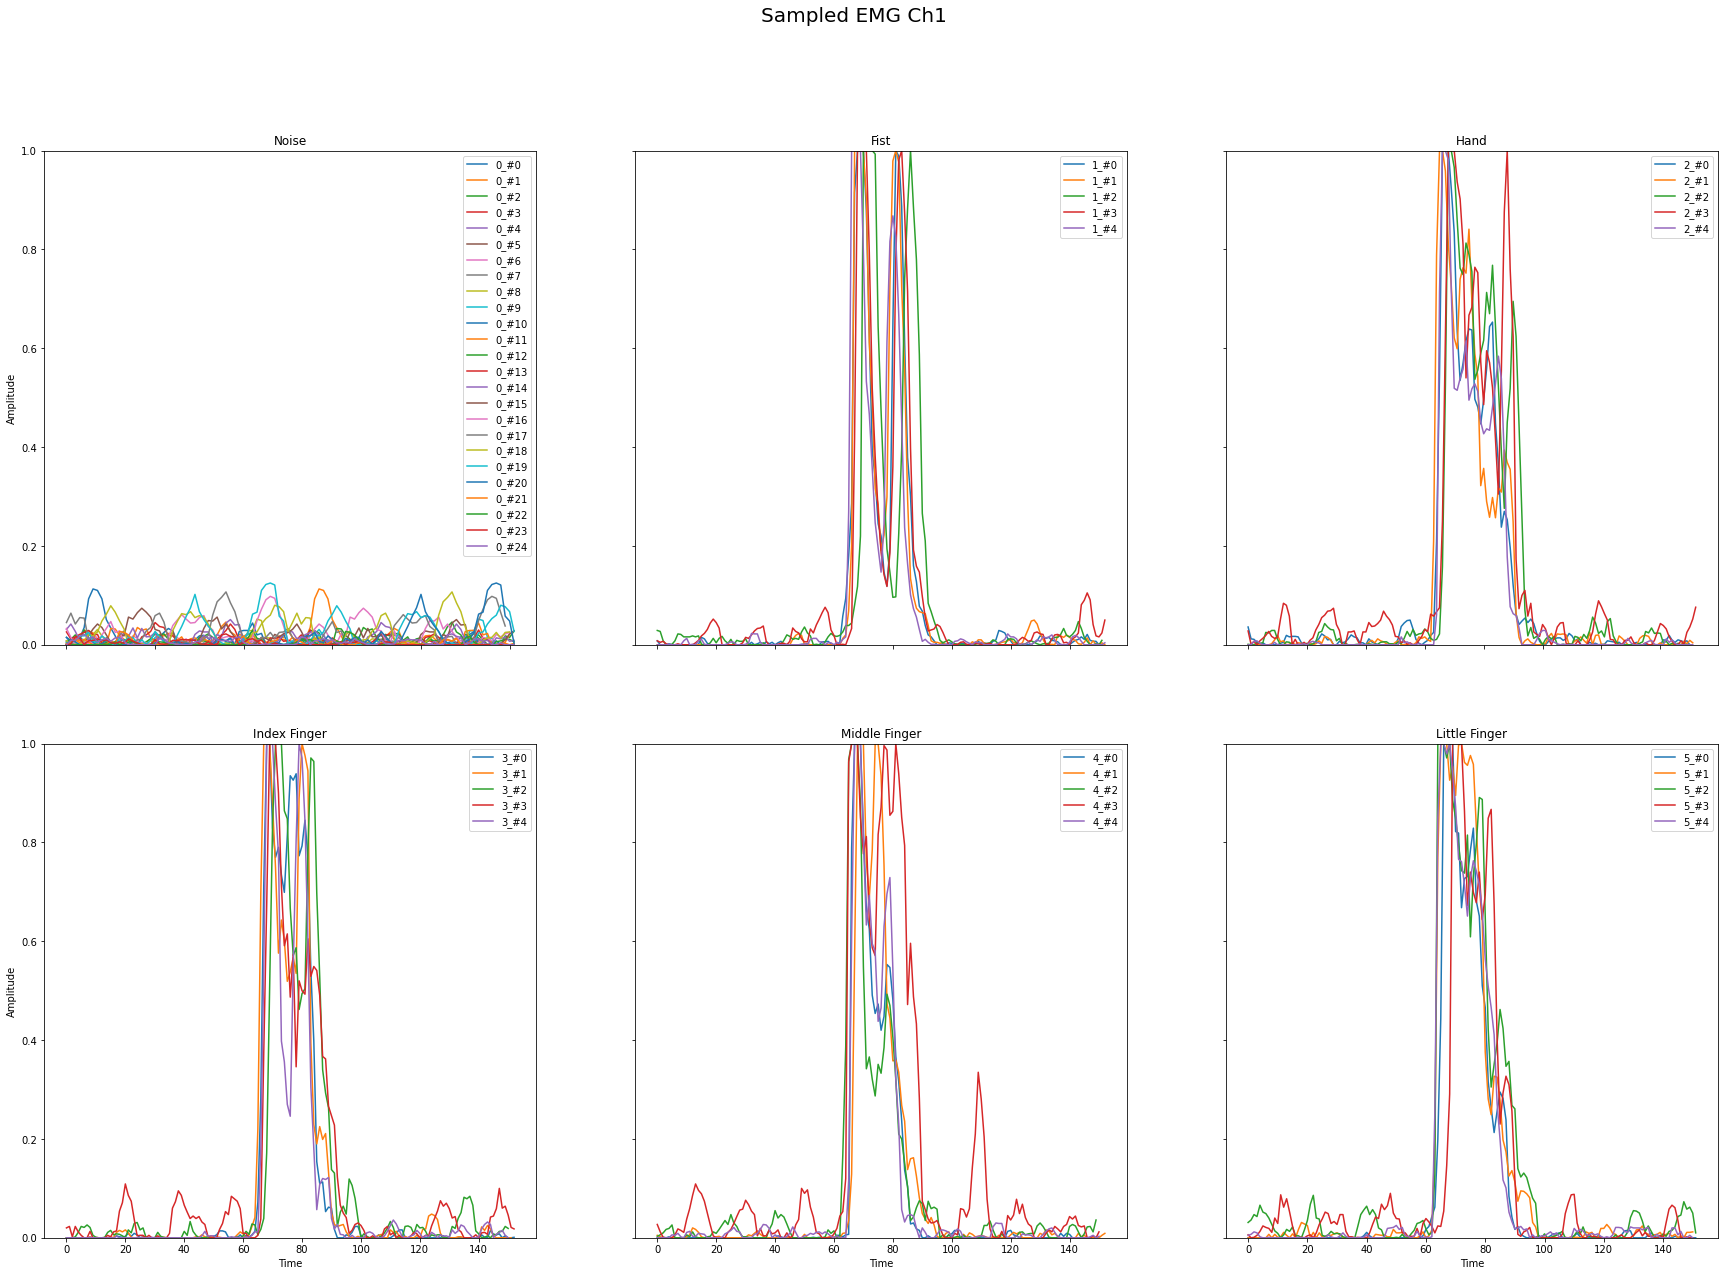

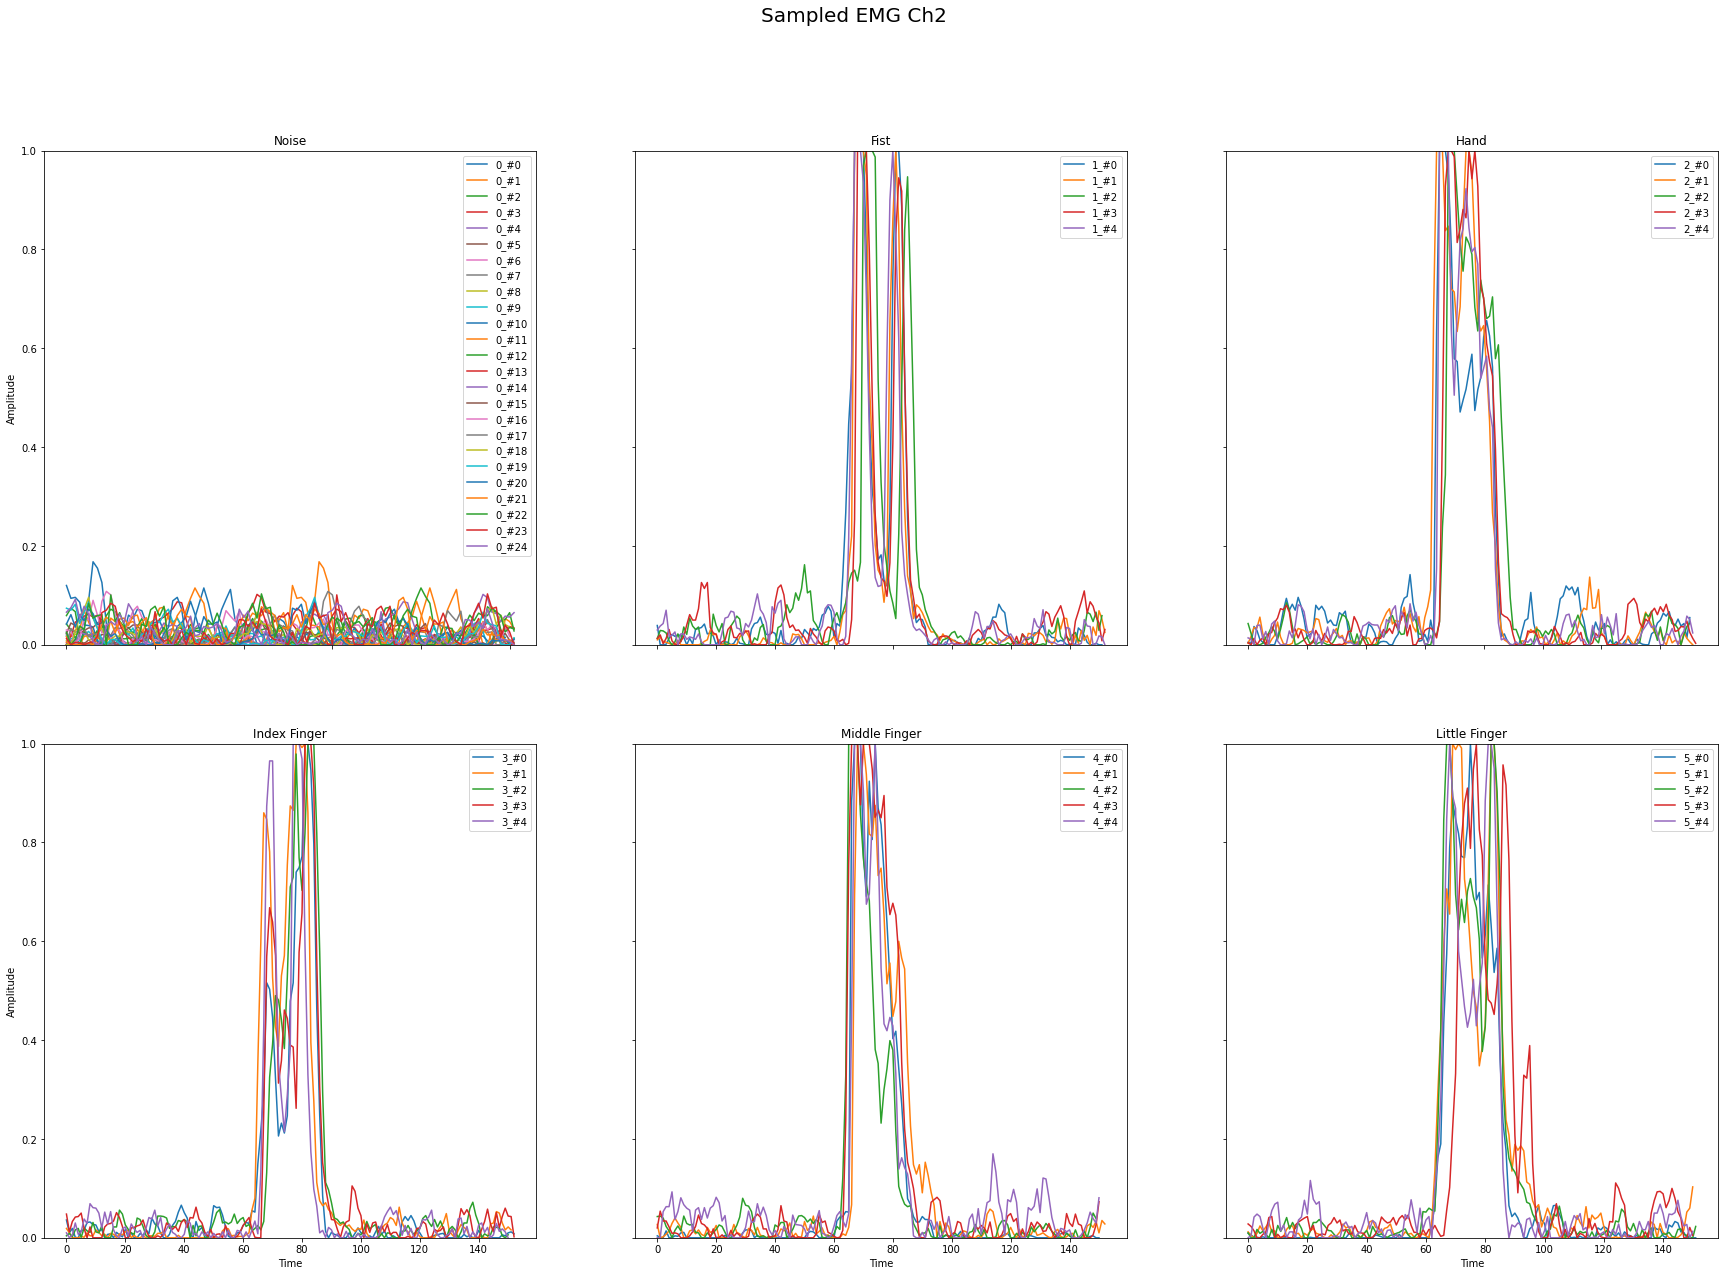

In [ ]:
# Graph Plotting
import matplotlib.pyplot as plt

gesture_name = ['Noise', 'Fist', 'Hand', 'Index Finger', 'Middle Finger', 'Little Finger']
plot_index = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
n_plot = 5


label_num = [0] * len(gesture_name)
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Sampled EMG Ch1', fontsize=20)
for data in X_train[:n_plot*2*(len(gesture_name)-1)]:
    g = int(data[1])
    axs[plot_index[g][0], plot_index[g][1]].plot(range(len(data[2::2])), data[2::2], label=f"{g}_#{label_num[g]}")
    label_num[g] += 1


i = 0
for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Amplitude', ylim=(0, 1))
    ax.set_title(gesture_name[i])
    ax.label_outer()
    ax.legend(loc="upper right")
    i += 1

label_num = [0] * len(gesture_name)
fig, axs = plt.subplots(2, 3, figsize=(30, 20))
fig.suptitle('Sampled EMG Ch2', fontsize=20)
for data in X_train[:n_plot*2*(len(gesture_name)-1)]:
    g = int(data[1])
    axs[plot_index[g][0], plot_index[g][1]].plot(range(len(data[3::2])), data[3::2], label=f"{g}_#{label_num[g]}")
    label_num[g] += 1


i = 0
for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Amplitude', ylim=(0, 1))
    ax.set_title(gesture_name[i])
    ax.label_outer()
    ax.legend(loc="upper right")
    i += 1

Preprocessing (Windowing, Filtering)

In [ ]:
def find_window_index(data, threshold):
  index = []
  for temp in data:
    if temp[1] == 0:
      index.append([0, len(temp) -1])
    else:
      ch1 = temp[2::2]
      ch2 = temp[3::2]
      start = min(next(x[0] for x in enumerate(ch1) if x[1] > threshold), next(x[0] for x in enumerate(ch2) if x[1] > threshold))
      end = len(ch1) - max(next(x[0] for x in enumerate(ch1[::-1]) if x[1] > threshold), next(x[0] for x in enumerate(ch2[::-1]) if x[1] > threshold)) -1
      index.append([start, end])

  return index

def window_shifting(data, w_index, seq_len):
  shifted_data = np.zeros((1, 2, seq_len))
  label = []
  for temp, w in zip(data, w_index):
    sample = np.array(temp[2::]).reshape((2, -1), order = 'F')
    for i in range(max(0, w[0]-seq_len), min(w[1], sample.shape[1]-seq_len)):
      shifted_data = np.append(shifted_data, [sample[:, i:i+seq_len]], axis = 0)
      label.append([temp[1]])
  shifted_data = np.delete(shifted_data, 0, axis = 0)
  return shifted_data, np.asarray(label)

# Window Streaming
seq_len = 64

%time w_index = find_window_index(X_train, 0.4)
%time input_train, label_train = window_shifting(X_train, w_index, seq_len)

%time input_train = np.swapaxes(input_train, 1, 2)

print(input_train.shape, label_train.shape)

'''
def window_data(seq_len,data) :
    res = [] # n * (128 X 2)
    num_ch = 2
    for i in range(data.shape[0] - seq_len + 1):
        tmp = []
        tmp.append(data[i:i+seq_len, 0:2])
        
        class_label = int(data[i,2])
        if(class_label == 0):
            tmp.append(0)
        elif(class_label == 1):
            tmp.append(1)
        elif(class_label == 2):
            tmp.append(2)
        elif(class_label == 3):
            tmp.append(3)
        
        res.append(tmp)
    return np.asarray(res)


training_data = window_data(seq_len, X_train)

input_train = training_data[:, 0]
label_train = training_data[:, 1]


# Filtering
from scipy import signal

def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

train_input = []
for data in input_train :
    train_input.append(data)
train_input = np.asarray(train_input)
print(train_input.shape)

label_input = []
for data in label_train :
    label_input.append(data)
label_input = np.asarray(label_input)
print(label_input.shape)

fps = 200

fData0 = []
fData1 = []
for data in train_input:
    data[:,0] = butter_highpass_filter(data[:,0],50,fps)
    data[:,1] = butter_highpass_filter(data[:,1],50,fps)

    fData0.append(data[0,0])
    fData1.append(data[0,1])
fData = []
fData.append(fData0)
fData.append(fData1)
fData = np.asarray(fData)

print(train_input.shape)
print(label_input.shape)
print(fData.shape)
'''

CPU times: user 9.07 ms, sys: 0 ns, total: 9.07 ms
Wall time: 10.3 ms
CPU times: user 3min 39s, sys: 5.86 s, total: 3min 45s
Wall time: 3min 45s
CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 16.9 µs
(45224, 64, 2) (45224, 1)


"\ndef window_data(seq_len,data) :\n    res = [] # n * (128 X 2)\n    num_ch = 2\n    for i in range(data.shape[0] - seq_len + 1):\n        tmp = []\n        tmp.append(data[i:i+seq_len, 0:2])\n        \n        class_label = int(data[i,2])\n        if(class_label == 0):\n            tmp.append(0)\n        elif(class_label == 1):\n            tmp.append(1)\n        elif(class_label == 2):\n            tmp.append(2)\n        elif(class_label == 3):\n            tmp.append(3)\n        \n        res.append(tmp)\n    return np.asarray(res)\n\n\ntraining_data = window_data(seq_len, X_train)\n\ninput_train = training_data[:, 0]\nlabel_train = training_data[:, 1]\n\n\n# Filtering\nfrom scipy import signal\n\ndef sine_generator(fs, sinefreq, duration):\n    T = duration\n    nsamples = fs * T\n    w = 2. * np.pi * sinefreq\n    t_sine = np.linspace(0, T, nsamples, endpoint=False)\n    y_sine = np.sin(w * t_sine)\n    result = pd.DataFrame({ \n        'data' : y_sine} ,index=t_sine)\n    return

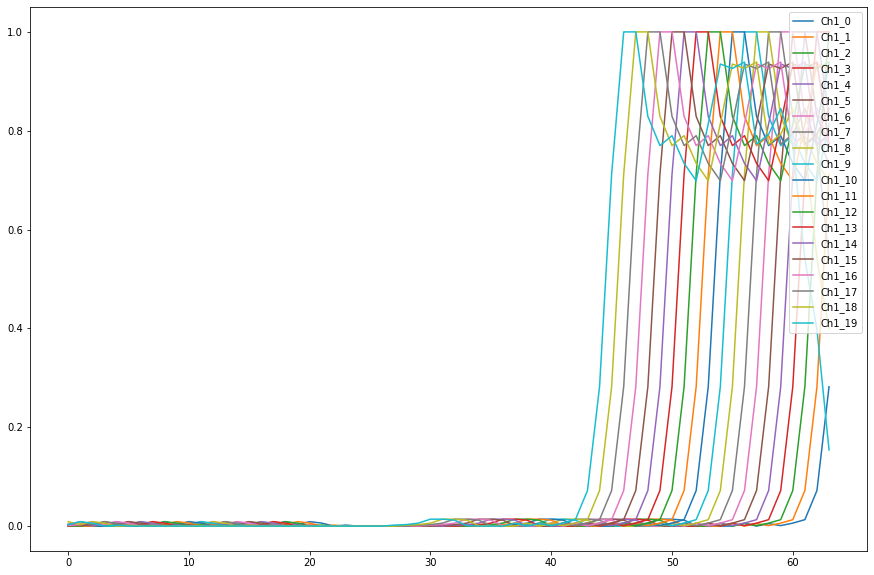

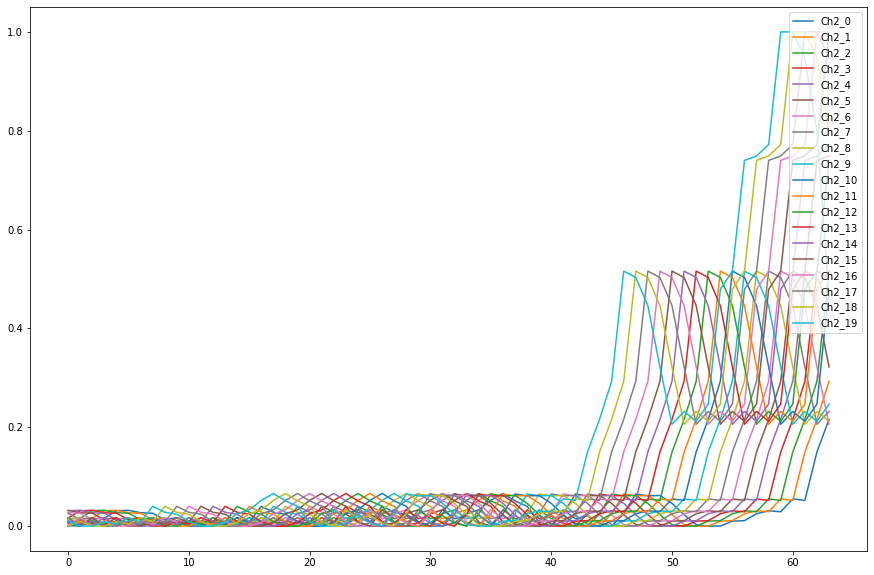

In [ ]:
# Shifted data graph
temp = np.where(label_train == 3)
temp = temp[0][0]
plt.figure(figsize = (15, 10))
i = 0
for data in input_train[temp:temp+20, :, 0]:
  plt.plot(data, label = f"Ch1_{i}")
  i += 1

plt.legend(loc = "upper right")
plt.show()

plt.figure(figsize = (15, 10))
i = 0
for data in input_train[temp:temp+20, :, 1]:
  plt.plot(data, label = f"Ch2_{i}")
  i += 1

plt.legend(loc = "upper right")
plt.show()

To Feed into the Network

In [ ]:
# Valid Set Split
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_tr, X_vld, lab_tr, lab_vld = train_test_split(input_train, label_train, stratify = label_train, random_state = 123)
print(X_tr.shape, X_vld.shape, lab_tr.shape, lab_vld.shape)

# Building tf.DataSet
dbs = tf.data.Dataset.from_tensor_slices((X_tr,lab_tr))
dbs = dbs.batch(128).repeat(3)

dbt = tf.data.Dataset.from_tensor_slices((X_vld,lab_vld))
dbt = dbt.batch(1).repeat(3)

print(dbs)
print(dbt)

(33918, 64, 2) (11306, 64, 2) (33918, 1) (11306, 1)
<RepeatDataset shapes: ((None, 64, 2), (None, 1)), types: (tf.float64, tf.int64)>
<RepeatDataset shapes: ((None, 64, 2), (None, 1)), types: (tf.float64, tf.int64)>


'\nX_tr, X_vld, lab_tr, lab_vld = train_test_split(\n    train_input, label_input,\n    stratify = label_input, random_state = 123)\n\nX_tr = X_tr.reshape(len(X_tr), -1, 1)\nX_vld = X_vld.reshape(len(X_vld), -1, 1)\n\nprint(X_tr.shape)\nprint(X_vld.shape)\nprint(lab_tr.shape)\nprint(lab_vld.shape)\n\n# Building tf.DataSet\ndbs = tf.data.Dataset.from_tensor_slices((X_tr,lab_tr))\ndbs = dbs.batch(128).repeat(3)\n\ndbt = tf.data.Dataset.from_tensor_slices((X_vld,lab_vld))\ndbt = dbt.batch(1).repeat(3)\n\nprint(dbs)\nprint(dbt)\n'

# Model (CNN)

In [ ]:
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import datasets, layers, optimizers, models

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=((64, 2)), kernel_size=3, filters=16, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((32, 2)), kernel_size=3, filters=32, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((16, 2)), kernel_size=2, filters=64, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((8, 2)), kernel_size=2, filters=128, padding = 'same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

'''
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=((1024,1)), kernel_size=128, filters=16, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((512,1)), kernel_size=128, filters=32, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((256,1)), kernel_size=64, filters=64, padding = 'same'),
  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),
  tf.keras.layers.Conv1D(input_shape=((128,1)), kernel_size=64, filters=128, padding = 'same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
'''

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 64, 16)            112       
_________________________________________________________________
average_pooling1d_6 (Average (None, 32, 16)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 32)            1568      
_________________________________________________________________
average_pooling1d_7 (Average (None, 16, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 64)            4160      
_________________________________________________________________
average_pooling1d_8 (Average (None, 8, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 128)           

"\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Conv1D(input_shape=((1024,1)), kernel_size=128, filters=16, padding = 'same'),\n  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),\n  tf.keras.layers.Conv1D(input_shape=((512,1)), kernel_size=128, filters=32, padding = 'same'),\n  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),\n  tf.keras.layers.Conv1D(input_shape=((256,1)), kernel_size=64, filters=64, padding = 'same'),\n  tf.keras.layers.AveragePooling1D(pool_size=2, strides=2),\n  tf.keras.layers.Conv1D(input_shape=((128,1)), kernel_size=64, filters=128, padding = 'same'),\n  tf.keras.layers.Flatten(),\n  tf.keras.layers.Dense(32, activation='relu'),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(4, activation='softmax')\n])\n\nmodel.compile(optimizer='adam',\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\nmodel.summary()\n"

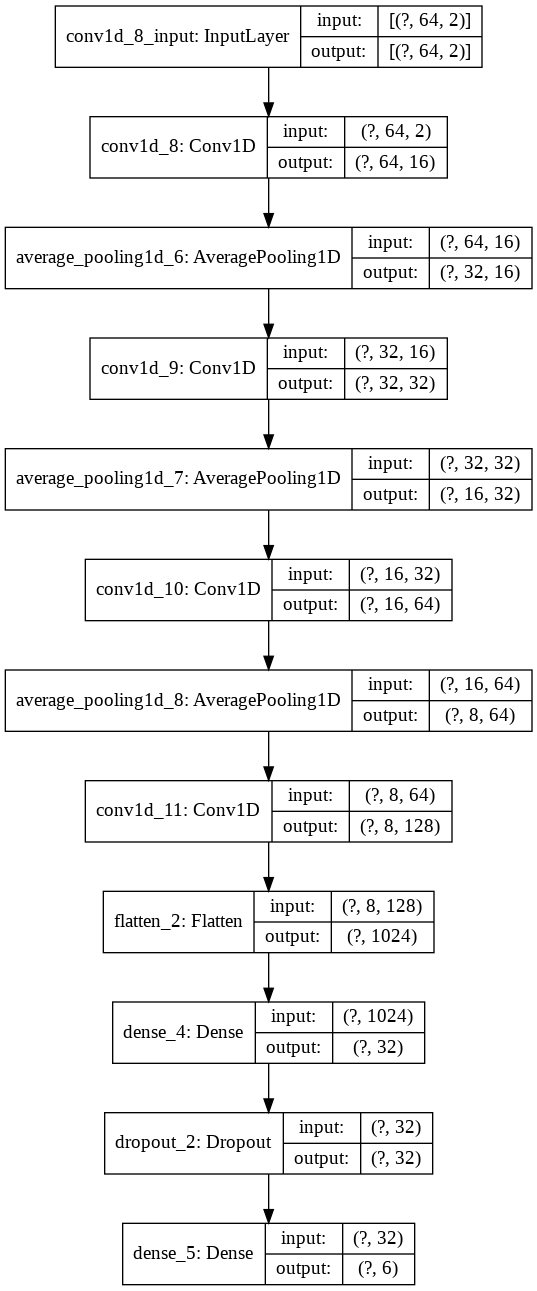

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

# Training & Testing

In [ ]:
history = model.fit(dbs, epochs = 50)

Epoch 1/50
795/795 [==============================] - 4s 6ms/step - loss: 0.7323 - accuracy: 0.6981
Epoch 2/50
795/795 [==============================] - 5s 6ms/step - loss: 0.5274 - accuracy: 0.7822
Epoch 3/50
795/795 [==============================] - 4s 6ms/step - loss: 0.4780 - accuracy: 0.8017
Epoch 4/50
795/795 [==============================] - 4s 6ms/step - loss: 0.4624 - accuracy: 0.8077
Epoch 5/50
795/795 [==============================] - 4s 6ms/step - loss: 0.4508 - accuracy: 0.8128
Epoch 6/50
795/795 [==============================] - 5s 6ms/step - loss: 0.4403 - accuracy: 0.8174
Epoch 7/50
795/795 [==============================] - 5s 6ms/step - loss: 0.4307 - accuracy: 0.8211
Epoch 8/50
795/795 [==============================] - 5s 6ms/step - loss: 0.4236 - accuracy: 0.8253
Epoch 9/50
795/795 [==============================] - 4s 6ms/step - loss: 0.4173 - accuracy: 0.8283
Epoch 10/50
795/795 [==============================] - 4s 6ms/step - loss: 0.4105 - accuracy: 0.8314

In [ ]:
for i in range(6):
  temp = np.where(lab_vld == i)
  dbt = tf.data.Dataset.from_tensor_slices((X_vld[temp[0]], lab_vld[temp[0]]))
  dbt = dbt.batch(1)
  results = model.evaluate(dbt)
  print(f"{i}-th gesture test loss, test acc: {results}")

3684/3684 [==============================] - 12s 3ms/step - loss: 0.0119 - accuracy: 0.9981
0-th gesture test loss, test acc: [0.011934426613152027, 0.9980998635292053]
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1693 - accuracy: 0.9473
1-th gesture test loss, test acc: [0.1693468689918518, 0.9473333358764648]
1540/1540 [==============================] - 5s 3ms/step - loss: 0.3634 - accuracy: 0.9279
2-th gesture test loss, test acc: [0.3634406626224518, 0.9279220700263977]
1561/1561 [==============================] - 5s 3ms/step - loss: 0.4743 - accuracy: 0.8053
3-th gesture test loss, test acc: [0.47433415055274963, 0.8052530288696289]
1488/1488 [==============================] - 4s 3ms/step - loss: 0.8152 - accuracy: 0.5645
4-th gesture test loss, test acc: [0.8151723146438599, 0.5645161271095276]
1533/1533 [==============================] - 4s 3ms/step - loss: 0.3946 - accuracy: 0.8408
5-th gesture test loss, test acc: [0.3945769965648651, 0.8408349752426147]


In [ ]:
# Saved to Data/my_model/
model.save(root_path_ + '/my_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Colab Notebooks/Data/my_model/assets
